# Convolutionalization

In this notebook, we explain the idea of convolutionalization, working with mnist digits.

Convolutionalization is the process of transforming a neural network containing dense layers (typically some classification network) into a fully convolutional one.

The fully convolutional network can be used as a detector kernel, convolving it over an input image to produce a "heat map" of the locations where objects are found.

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, GlobalMaxPool2D, MaxPool2D, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

2023-04-05 12:46:48.079115: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-05 12:46:48.403630: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-05 12:46:48.403651: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-05 12:46:49.946453: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

Here we load the mnist dataset

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(60000,28,28,1)/255.
x_test = x_test.reshape(10000,28,28,1)/255.
print(x_train.shape)
print(x_train.min())
print(x_train.max())

(60000, 28, 28, 1)
0.0
1.0


It is convenient to add to the detector a "background" class, containing no object. For traning and testing we create a bunch of images "almost black" (to be refined as an exercise).

In [3]:
background = np.random.randint(0,5,(6000,28,28,1))/255.
background_test = np.random.randint(0,5,(1000,28,28,1))/255.

Let us see an example of background, together with a typical image.

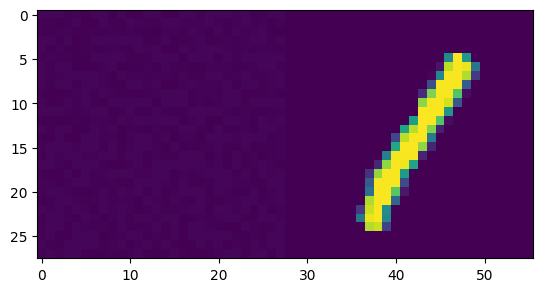

In [4]:
imageplot = plt.imshow(np.reshape(np.concatenate((background[15],x_train[23]),axis=1),(28,56)))
plt.show()

We extend the training set. Backgound gets label "10".

In [5]:
x_train_bg = np.concatenate((x_train,background))
x_test_bg = np.concatenate((x_test,background_test))
y_train_bg = np.concatenate((y_train,np.ones(6000)*10))
y_test_bg = np.concatenate((y_test,np.ones(1000)*10))

In [6]:
print(x_train_bg.shape)

(66000, 28, 28, 1)


The classifier is composed by an initial part made by 2Dconvolutional layers, followed by two dense layers (intermixed by dropout).

Every other convolution has stride 2, halving the size of the input. At the same time we double the channel dimension, to partially compensate the dimensionality loss.


In [7]:
iimg = Input(shape=(28,28,1))
x = Conv2D(16,(3,3),strides=2,padding='same', activation='swish')(iimg)
x = Conv2D(32,(3,3),strides=2,padding='same',activation='swish')(x)
x = Conv2D(64,(3,3),strides=2,padding='same',activation='swish')(x)
x = GlobalMaxPool2D()(x)
x = Dense(64,activation = 'swish')(x)
cout = Dense(11, activation = 'softmax')(x) #we have now 11 categories

model = Model(inputs=[iimg],outputs=[cout])

2023-04-05 12:49:05.037480: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-04-05 12:49:05.037572: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (andrea): /proc/driver/nvidia/version does not exist
2023-04-05 12:49:05.038273: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Here is the model summary. 

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 32)          4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 global_max_pooling2d (Globa  (None, 64)               0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                             

We compile the model with (sparse) categorical crossentropy. 
Recall that the training set is automatically shuffled by the fit method.

We add accuracy as additional metric to evaluate the model.

In [9]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

Ten epochs of training should be enough.

In [10]:
model.fit(x_train_bg,y_train_bg,
          epochs=10,
          batch_size=100,
          validation_data=(x_test_bg, y_test_bg))

Epoch 1/10


2023-04-05 12:49:22.684267: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 206976000 exceeds 10% of free system memory.


660/660 [==============================] - ETA: 0s - loss: 0.4466 - accuracy: 0.8623

2023-04-05 12:49:42.561121: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 34496000 exceeds 10% of free system memory.


660/660 [==============================] - 21s 29ms/step - loss: 0.4466 - accuracy: 0.8623 - val_loss: 0.1487 - val_accuracy: 0.9559
Epoch 2/10
660/660 [==============================] - 18s 28ms/step - loss: 0.1270 - accuracy: 0.9622 - val_loss: 0.0935 - val_accuracy: 0.9718
Epoch 3/10
660/660 [==============================] - 16s 25ms/step - loss: 0.0861 - accuracy: 0.9744 - val_loss: 0.0694 - val_accuracy: 0.9796
Epoch 4/10
660/660 [==============================] - 15s 23ms/step - loss: 0.0651 - accuracy: 0.9801 - val_loss: 0.0608 - val_accuracy: 0.9812
Epoch 5/10
660/660 [==============================] - 14s 22ms/step - loss: 0.0524 - accuracy: 0.9840 - val_loss: 0.0605 - val_accuracy: 0.9819
Epoch 6/10
660/660 [==============================] - 15s 23ms/step - loss: 0.0437 - accuracy: 0.9864 - val_loss: 0.0537 - val_accuracy: 0.9823
Epoch 7/10
660/660 [==============================] - 15s 23ms/step - loss: 0.0381 - accuracy: 0.9876 - val_loss: 0.0469 - val_accuracy: 0.9856
Epo

Let us save the weights, since we need them.

In [11]:
model.save_weights("convolutionalization_mymodel.hdf5")

Now we define a fully convolutional network. We aim to obtain in output a feature map, that is a 2D image.

A simple way to do it is to directly apply the Dense layers to the 3D features maps before maxpooling. In tensorflow, this is equivalent to apply a unary convolution, that is the dense layer only operates on channels.

In [12]:
iimg = Input(shape=(None,None,1))
x = Conv2D(16,(3,3),strides=2,padding='same', activation='swish',name="l1")(iimg)
x = Conv2D(32,(3,3),strides=2,padding='same',activation='swish',name="l2")(x)
x = Conv2D(64,(3,3),strides=2,padding='same',activation='swish',name="l3")(x)
#x = MaxPool2D((3,3),padding='same',strides=1)(x)
x = Dense(64,activation = 'swish')(x)
cout = Dense(11, activation = 'softmax')(x) 

model_c = Model(inputs=[iimg],outputs=[cout])

Let us see the summary. 

Observe that the spatial dimension of the input is unspecified and that we get a spatial heat map as output. 

To better understand the relation between the input-output spatial dimensions fix the some shapes for inputs and recompute the summary.

In [13]:
model_c.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 l1 (Conv2D)                 (None, None, None, 16)    160       
                                                                 
 l2 (Conv2D)                 (None, None, None, 32)    4640      
                                                                 
 l3 (Conv2D)                 (None, None, None, 64)    18496     
                                                                 
 dense_2 (Dense)             (None, None, None, 64)    4160      
                                                                 
 dense_3 (Dense)             (None, None, None, 11)    715       
                                                                 
Total params: 28,171
Trainable params: 28,171
Non-trainable

The previous fully convolutional network has precisely the same parameters of the previous classifier, so we can just load the saved weights.



In [14]:
model_c.load_weights("convolutionalization_mymodel.hdf5")

Let us create an image composed by several mnist digits.

In [15]:
rimg = np.zeros((128,128,1))
rimg[12:40,6:34] = x_test[15]
rimg[40:68,30:58] = x_test[14]
rimg[15:43,45:73] = x_test[13]
rimg[5:33,75:103] = x_test[12]
rimg[45:73,90:118] = x_test[11]
rimg[89:117,70:98] = x_test[9]
rimg[80:108,25:53] = x_test[6]

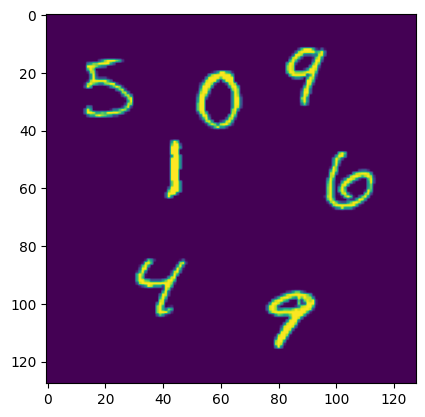

In [16]:
imageplot = plt.imshow(np.reshape(rimg,(128,128)))
plt.show()

We use the cmap function of pyplot to map classes to colors.

In [17]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

cmap = get_cmap(12)

def cmap1(n):
  return cmap(n)[0:3]

print(cmap1(3),cmap1(10))

(0.38920293465748, 1.0, 0.0) (1.0, 0.0, 0.6306823551141734)


Now we try to use the fully convolutional network to "locate" digits in out sample image.

In [18]:
fmap = model_c.predict(np.expand_dims(rimg,axis=0))[0]
print(fmap.shape)

1/1 [==============================] - 0s 197ms/step
(16, 16, 11)


In [19]:
fmap = np.argmax(fmap,axis=-1)
print(fmap.shape)
print(fmap)

(16, 16)
[[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]
 [10 10  5 10 10 10 10 10 10 10  4  7 10 10 10 10]
 [10  5  5 10 10 10  0  7 10 10  7 10 10 10 10 10]
 [10  5  5 10 10 10  4  1 10 10 10 10 10 10 10 10]
 [10 10 10 10 10 10  5  1 10 10 10 10 10 10 10 10]
 [10 10 10 10  1  9 10 10 10 10 10 10 10 10 10 10]
 [10 10 10 10  1  9 10 10 10 10 10  1  6  7 10 10]
 [10 10 10 10 10  5 10 10 10 10 10  8  6 10 10 10]
 [10 10 10 10 10 10 10 10 10 10 10 10  4 10 10 10]
 [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]
 [10 10 10  1  8 10 10 10 10 10 10 10 10 10 10 10]
 [10 10 10  5  7 10 10 10 10 10  3 10 10 10 10 10]
 [10 10 10 10  5 10 10 10 10  9  3 10 10 10 10 10]
 [10 10 10 10 10 10 10 10 10  1  1 10 10 10 10 10]
 [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]
 [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]]


The result is better appreciated as a heatmap.

In [20]:
vcmap = np.vectorize(cmap1)
fcmap = np.array(vcmap(fmap))
fcmap = np.transpose(fcmap,(1,2,0))
print(fcmap.shape)

(16, 16, 3)


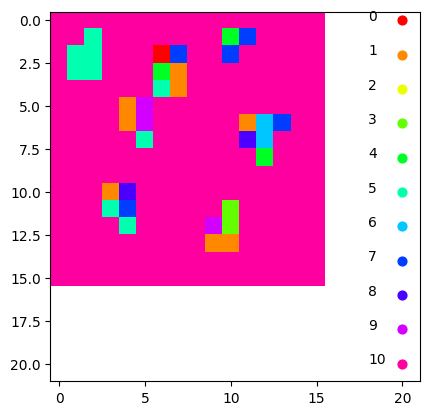

In [21]:
fig,ax = plt.subplots()
ax.imshow(fcmap)
for i in range(11):
  ax.text(18,2*i,str(i))
  ax.scatter(20,2*i,s=40,color=cmap1(i))
plt.show()

Location is good but classification is not always accurate.

#Improvements

Let us try to improve things by training a classifier more robust to dispacements (mnist data are precisely centered, while the stride of the convolutional network is 8).

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        #rotation_range=0.1,
        width_shift_range=0.2,
        height_shift_range=0.2,
        #shear_range=0.15,
        #zoom_range=0.15,
        horizontal_flip=False,
        fill_mode='nearest')

Let's look at sample samples of augmement data:

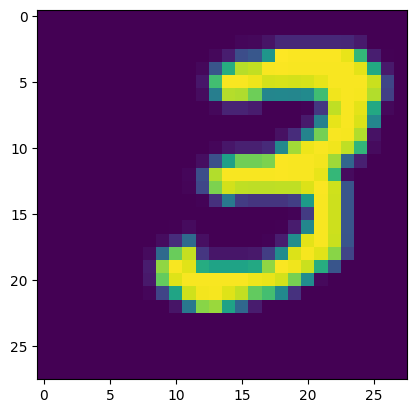

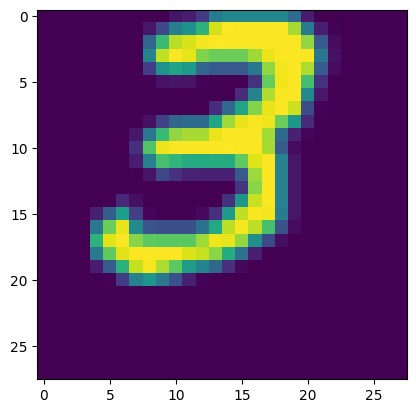

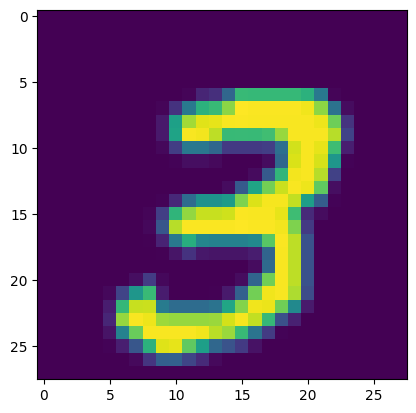

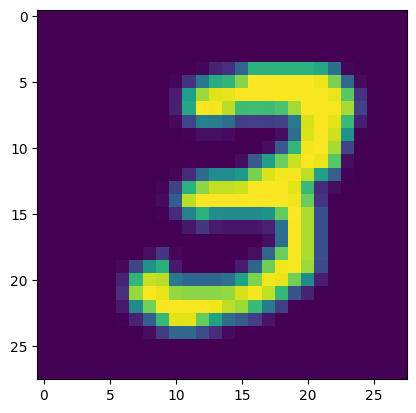

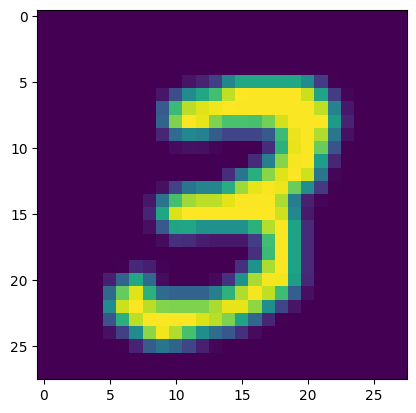

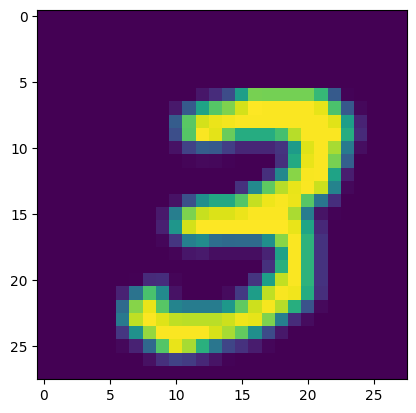

In [23]:
i = 0
for batch in datagen.flow(x_train[7:8], batch_size=1):
    i += 1
    plt.imshow(batch[0,:,:,0])
    plt.show()
    if i > 5:
        break  # otherwise the generator would loop indefinitely

In [24]:
train_generator = datagen.flow(x_train_bg,y_train_bg,batch_size=100)

In [25]:
model.fit(train_generator,
          steps_per_epoch = 600,
          epochs=5,
          validation_data=(x_test_bg, y_test_bg))

Epoch 1/5
600/600 [==============================] - ETA: 0s - loss: 0.2211 - accuracy: 0.9309

2023-04-05 12:56:10.888567: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 34496000 exceeds 10% of free system memory.


600/600 [==============================] - 55s 90ms/step - loss: 0.2211 - accuracy: 0.9309 - val_loss: 0.1019 - val_accuracy: 0.9675
Epoch 2/5
600/600 [==============================] - 57s 94ms/step - loss: 0.1173 - accuracy: 0.9634 - val_loss: 0.0832 - val_accuracy: 0.9725
Epoch 3/5
600/600 [==============================] - 59s 98ms/step - loss: 0.0953 - accuracy: 0.9697 - val_loss: 0.0855 - val_accuracy: 0.9720
Epoch 4/5
600/600 [==============================] - 59s 98ms/step - loss: 0.0867 - accuracy: 0.9730 - val_loss: 0.0818 - val_accuracy: 0.9732
Epoch 5/5
600/600 [==============================] - 59s 98ms/step - loss: 0.0784 - accuracy: 0.9750 - val_loss: 0.0878 - val_accuracy: 0.9711


In [26]:
model.save_weights("convolutionalization_mymodel_bis.hdf5")

In [27]:
model_c.load_weights("convolutionalization_mymodel_bis.hdf5")

In [28]:
fmap = model_c.predict(np.expand_dims(rimg,axis=0))[0]
fmap = np.argmax(fmap,axis=-1)
print(fmap)
fcmap = np.array(vcmap(fmap))
fcmap = np.transpose(fcmap,(1,2,0))
print(fcmap.shape)

1/1 [==============================] - 0s 66ms/step
[[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]
 [10  0 10 10 10 10 10 10 10 10  0  7 10 10 10 10]
 [10  5  5 10 10 10  1  7 10 10  7  8 10 10 10 10]
 [10 10  3 10 10 10  6  7 10 10 10 10 10 10 10 10]
 [10  2  0 10 10 10  4  5 10 10 10 10 10 10 10 10]
 [10 10 10 10  1  1 10 10 10 10 10 10 10 10 10 10]
 [10 10 10 10  1  1 10 10 10 10 10  1  6  9 10 10]
 [10 10 10 10 10 10 10 10 10 10 10  4  6 10 10 10]
 [10 10 10 10 10 10 10 10 10 10 10 10  2 10 10 10]
 [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]
 [10 10 10  1  4 10 10 10 10 10 10 10 10 10 10 10]
 [10 10 10  2  7 10 10 10 10  1 10 10 10 10 10 10]
 [10 10 10 10  5 10 10 10 10  9  7 10 10 10 10 10]
 [10 10 10 10 10 10 10 10 10  7 10 10 10 10 10 10]
 [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]
 [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]]
(16, 16, 3)


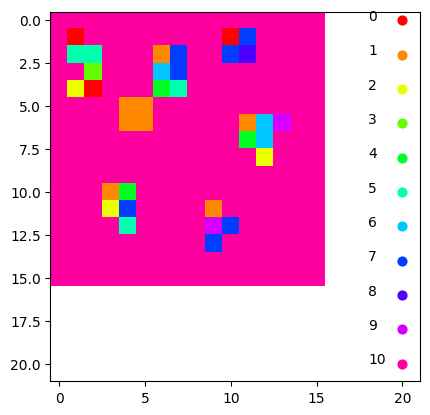

In [29]:
fig,ax = plt.subplots()
ax.imshow(fcmap)
for i in range(11):
  ax.text(18,2*i,str(i))
  ax.scatter(20,2*i,s=40,color=cmap1(i))
plt.show()

As a second attemp we consider a sligtly more sophisticated classifier.

In [30]:
iimg = Input(shape=(28,28,1))
x = Conv2D(16,(3,3),strides=2,padding='same', activation='swish')(iimg)
x = Conv2D(16,(3,3),strides=1,padding='same',activation='swish')(x)
x = Conv2D(32,(3,3),strides=2,padding='same',activation='swish')(x)
x = Conv2D(32,(3,3),strides=1,padding='same',activation='swish')(x)
x = Conv2D(64,(3,3),strides=2,padding='same',activation='swish')(x)
x = Conv2D(64,(3,3),strides=1,padding='same',activation='swish')(x)
x = GlobalMaxPool2D()(x)
x = Dense(64,activation = 'swish')(x)
cout = Dense(11, activation = 'softmax')(x) #we have now 11 categories

model2 = Model(inputs=[iimg],outputs=[cout])

In [31]:
model2.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [32]:
model2.fit(train_generator,
          steps_per_epoch = 600,
          epochs=5,
          validation_data=(x_test_bg, y_test_bg))

Epoch 1/5
  2/600 [..............................] - ETA: 1:17 - loss: 2.3980 - accuracy: 0.0700 

2023-04-05 13:00:54.953266: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 26417664 exceeds 10% of free system memory.
2023-04-05 13:00:54.953371: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 26417664 exceeds 10% of free system memory.


600/600 [==============================] - 41s 66ms/step - loss: 0.5447 - accuracy: 0.8160 - val_loss: 0.1506 - val_accuracy: 0.9517
Epoch 2/5
600/600 [==============================] - 38s 64ms/step - loss: 0.1334 - accuracy: 0.9592 - val_loss: 0.0935 - val_accuracy: 0.9712
Epoch 3/5
600/600 [==============================] - 36s 59ms/step - loss: 0.0901 - accuracy: 0.9715 - val_loss: 0.0697 - val_accuracy: 0.9779
Epoch 4/5
600/600 [==============================] - 36s 60ms/step - loss: 0.0725 - accuracy: 0.9778 - val_loss: 0.0715 - val_accuracy: 0.9785
Epoch 5/5
600/600 [==============================] - 37s 61ms/step - loss: 0.0587 - accuracy: 0.9818 - val_loss: 0.0654 - val_accuracy: 0.9792


In [33]:
model2.save_weights("convolutionalization_mymodel2.hdf5")

Now we convolutionalize the previous calssifier. In this case, we also leave a pooling layer after the convolution. Since we do not want to further decrease the spatial dimension of the feature map, we apply it with stride 1 (the default stride for pooling layers is equal to the dimension of the kernel).

In [35]:
iimg = Input(shape=(None,None,1))
x = Conv2D(16,(3,3),strides=2,padding='same', activation='swish')(iimg)
x = Conv2D(16,(3,3),strides=1,padding='same',activation='swish')(x)
x = Conv2D(32,(3,3),strides=2,padding='same',activation='swish')(x)
x = Conv2D(32,(3,3),strides=1,padding='same',activation='swish')(x)
x = Conv2D(64,(3,3),strides=2,padding='same',activation='swish')(x)
x = Conv2D(64,(3,3),strides=1,padding='same',activation='swish')(x)
x = MaxPool2D((3,3),padding='same',strides=1)(x)
x = Dense(64,activation = 'swish')(x)
cout = Dense(11, activation = 'softmax')(x) 

model2_c = Model(inputs=[iimg],outputs=[cout])
model2_c.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d_15 (Conv2D)          (None, None, None, 16)    160       
                                                                 
 conv2d_16 (Conv2D)          (None, None, None, 16)    2320      
                                                                 
 conv2d_17 (Conv2D)          (None, None, None, 32)    4640      
                                                                 
 conv2d_18 (Conv2D)          (None, None, None, 32)    9248      
                                                                 
 conv2d_19 (Conv2D)          (None, None, None, 64)    18496     
                                                                 
 conv2d_20 (Conv2D)          (None, None, None, 64)    3692

In [36]:
model2_c.load_weights("convolutionalization_mymodel2.hdf5")

In [37]:
fmap = model2_c.predict(np.expand_dims(rimg,axis=0))[0]
fmap = np.argmax(fmap,axis=-1)
print(fmap)
fcmap = np.array(vcmap(fmap))
fcmap = np.transpose(fcmap,(1,2,0))
print(fcmap.shape)

1/1 [==============================] - 0s 271ms/step
[[ 5  5  5  5 10 10 10 10 10  0  0  0  8 10 10 10]
 [ 5  5  5  5  5 10  0  0  0  9  9  9  8 10 10 10]
 [ 5  5  5  5  5  0  0  0  0  9  9  9  9 10 10 10]
 [ 5  5  5  5  5  0  0  0  0  7  9  9  5 10 10 10]
 [10  5  5  5  0  6  0  0  0 10 10 10 10 10 10 10]
 [10 10 10 10  1  1  1 10 10 10 10  6  6  6  0 10]
 [10 10 10 10  1  1  1 10 10 10 10  6  6  6  6 10]
 [10 10 10 10 10 10 10 10 10 10 10  6  6  6  0 10]
 [10 10 10 10 10 10 10 10 10 10 10  6  6  6 10 10]
 [10 10 10  0  0  0  5 10 10 10 10 10 10 10 10 10]
 [10 10 10  4  4  4  5 10 10 10  0 10 10 10 10 10]
 [10 10 10  4  4  4  5 10  9  9  9  8 10 10 10 10]
 [10 10 10  7  4  7 10 10  0  9  9  9 10 10 10 10]
 [10 10 10 10 10 10 10 10  9  7  7  7 10 10 10 10]
 [10 10 10 10 10 10 10 10 10  7  7 10 10 10 10 10]
 [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]]
(16, 16, 3)


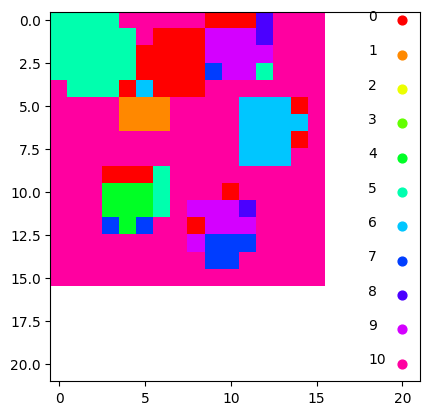

In [38]:
fig,ax = plt.subplots()
ax.imshow(fcmap)
for i in range(11):
  ax.text(18,2*i,str(i))
  ax.scatter(20,2*i,s=40,color=cmap1(i))
plt.show()